In [1]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time

from utils import *

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv2\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv2\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not exp

## Load data

In [2]:
paths = {
    'train': {'images':   r"data/sam_finetuning/train/images/",
              'masks':    r"data/sam_finetuning/train/masks/",
              'bboxes':   r"data/sam_finetuning/train/bboxes/"},
    'val':   {'images':   r"data/sam_finetuning/val/images/",
              'masks':    r"data/sam_finetuning/val/masks/",
              'bboxes':   r"data/sam_finetuning/val/bboxes/"},
    'test':  {'images':   r"data/sam_finetuning/test/images/",
              'masks':    r"data/sam_finetuning/test/masks/",
              'bboxes':   r"data/sam_finetuning/test/bboxes/"}
}

train_images = get_images(paths['train']['images'])
val_images   = get_images(paths['val']['images'])
test_images  = get_images(paths['test']['images'])

train_masks  = get_images(paths['train']['masks'])
val_masks    = get_images(paths['val']['masks'])
test_masks   = get_images(paths['test']['masks'])

n_train = len(train_images)
n_val   = len(val_images)
n_test  = len(test_images)

print(f'num train_images: {n_train}')
print(f'num val_images: {n_val}')
print(f'num test_images: {n_test}')

original_dims = (512, 641)

num train_images: 411
num val_images: 102
num test_images: 101


In [3]:
train_images.shape

AttributeError: 'dict' object has no attribute 'shape'

## Helper functions

In [112]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

def prepare_datasets(patch_size: int, image_dims: tuple[int, int]) -> tuple[Dataset]:
    step = patch_size

    x_factor = original_dims[1] / image_dims[1]
    y_factor = original_dims[0] / image_dims[0]

    # Combine train and val images as train
    train_img_patches = []
    train_mask_patches = []
    # train_bbox_patches = []
    
    val_img_patches = []
    val_mask_patches = []
    # val_bbox_patches = []

    test_img_patches = []
    test_mask_patches = []
    # test_bbox_patches = []

    # Process train images
    i = 0
    for key in tqdm(train_images):
        # Load and resize image
        img = train_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                train_img_patches.append(single_patch_img)
        
        # Load and resize mask
        mask = train_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)
        
        # # Load and resize bbox
        # (x, y), w, h = train_bboxes[key]
        # bbox = (round(x/x_factor), round(y/y_factor), round(w/x_factor), round(h/y_factor))
        
        i += 1

    # Process val images
    # i = 0
    for key in tqdm(val_images):
        # Load and resize image
        img = val_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                val_img_patches.append(single_patch_img)
                # train_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = val_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                val_mask_patches.append(single_patch_mask)
                # train_mask_patches.append(single_patch_mask)
        
        i += 1

    # Process test images
    i = 0
    for key in tqdm(test_images):
        # Load and resize image
        img = test_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                test_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = test_masks[key][:, :, 0] / 255
        mask = np.array(mask, dtype=np.uint8)
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                test_mask_patches.append(single_patch_mask)
        
        i += 1 
        
    X_train = np.array(train_img_patches)
    Y_train = np.array(train_mask_patches)
    
    X_val = np.array(val_img_patches)
    Y_val = np.array(val_mask_patches)

    X_test = np.array(test_img_patches)
    Y_test = np.array(test_mask_patches)

    # Have balanced classes
    valid_indices = [i for i, mask in enumerate(Y_train) if mask.max() != 0]
    num_valid = len(valid_indices) * 3
    count = 0
    for i, mask in enumerate(Y_train):
        if mask.max() == 0 and count < num_valid:
            count += 1
            new_mask = np.zeros_like(mask)
            new_mask[0,0] = 1
            Y_train[i] = new_mask
            valid_indices.append(i)
    X_train = X_train[valid_indices]
    Y_train = Y_train[valid_indices]
    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_val) if mask.max() != 0]
    num_valid = len(valid_indices) * 3
    count = 0
    for i, mask in enumerate(Y_val):
        if mask.max() == 0 and count < num_valid:
            count += 1
            new_mask = np.zeros_like(mask)
            new_mask[0,0] = 1
            Y_val[i] = new_mask
            valid_indices.append(i)
    X_val = X_val[valid_indices]
    Y_val = Y_val[valid_indices]
    print("X_val shape:", X_val.shape)
    print("Y_val shape:", Y_val.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_test) if mask.max() != 0]
    num_valid = len(valid_indices) * 3
    count = 0
    for i, mask in enumerate(Y_test):
        if mask.max() == 0 and count < num_valid:
            count += 1
            new_mask = np.zeros_like(mask)
            new_mask[0,0] = 1
            Y_test[i] = new_mask
            valid_indices.append(i)
    X_test = X_test[valid_indices]
    Y_test = Y_test[valid_indices]
    print("X_test shape:", X_test.shape)
    print("Y_test shape:", Y_test.shape)
    
    train_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_train],
        "mask":  [Image.fromarray(mask) for mask in Y_train],
    }
    val_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_val],
        "mask":  [Image.fromarray(mask) for mask in Y_val],
    }
    test_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_test],
        "mask":  [Image.fromarray(mask) for mask in Y_test],
    }

    train_dataset = Dataset.from_dict(train_dict)
    val_dataset  = Dataset.from_dict(val_dict)
    test_dataset  = Dataset.from_dict(test_dict)
    
    return train_dataset, val_dataset, test_dataset

# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

## Prepare datasets

In [113]:
patch_size = 256
image_size = 512

train_dataset, val_dataset, test_dataset = prepare_datasets(patch_size, (image_size, image_size))

100%|██████████| 101/101 [00:00<00:00, 234.85it/s]


X_train shape: (1644, 256, 256, 3)
Y_train shape: (1644, 256, 256)
X_val shape: (408, 256, 256, 3)
Y_val shape: (408, 256, 256)
X_test shape: (404, 256, 256, 3)
Y_test shape: (404, 256, 256)


In [114]:
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['image', 'mask'],
     num_rows: 1644
 }),
 Dataset({
     features: ['image', 'mask'],
     num_rows: 408
 }),
 Dataset({
     features: ['image', 'mask'],
     num_rows: 404
 }))

## Display random datapoint

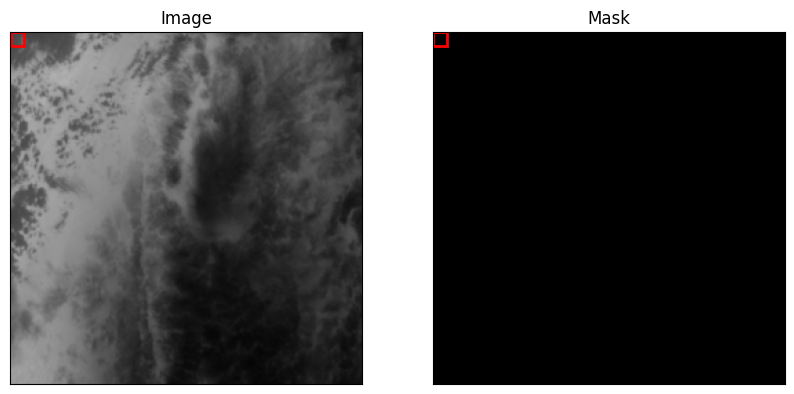

In [115]:
img_num = random.randint(0, len(train_dataset)-1)
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["mask"]
# example_bbox = train_dataset[img_num]["bbox"]

bbox = get_bounding_box(np.array(example_mask))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the iamge on left
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the mask on right
axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    rect_pred = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    # rect_true = Rectangle((example_bbox[0], example_bbox[1]), example_bbox[2], example_bbox[3], linewidth=2, edgecolor='g', facecolor='none')
    
    ax.add_patch(rect_pred)
    # ax.add_patch(rect_true)

plt.show()

## Dataset class

In [116]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    Used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        
        ground_truth_mask = np.array(item["mask"])

        # Get bounding box prompt
        # prompt = get_bounding_box(ground_truth_mask)
        prompt = [0, 0, 256, 256]

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        
        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        
        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask
        
        return inputs

## Make datasets

In [117]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_sam_dataset = SAMDataset(dataset=train_dataset, processor=processor)
val_sam_dataset = SAMDataset(dataset=val_dataset, processor=processor)
test_sam_dataset = SAMDataset(dataset=test_dataset, processor=processor)

In [118]:
example = train_sam_dataset[0]
for k,v in example.items():
    print(k,v.shape)
    
example['pixel_values'].max()

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


tensor(0.7054)

In [119]:
example['ground_truth_mask'].max()

1

In [120]:
from torch.utils.data import DataLoader

batch_size = 2

train_dataloader = DataLoader(train_sam_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_sam_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_sam_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [121]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)
    
batch["ground_truth_mask"].max()

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


tensor(1, dtype=torch.uint8)

## Train

In [122]:
# from transformers import Trainer, TrainingArguments
# from transformers import SamModel, SamConfig, SamProcessor
# from torch.optim import Adam
# import monai

# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# device = get_device()
# torch.cuda.empty_cache()

# model = SamModel.from_pretrained("facebook/sam-vit-base")

# # make sure we only compute gradients for mask decoder
# for name, param in model.named_parameters():
#     if name.startswith("vision_encoder") or name.startswith("prompt_encoder") or name.startswith("image_encoder"):
#         param.requires_grad_(False)

# class RegressionTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         outputs = model(pixel_values=inputs["pixel_values"].to(device),
#                         input_boxes=inputs["input_boxes"].to(device),
#                         multimask_output=False)

#         # compute loss
#         predicted_masks = outputs.pred_masks.squeeze(1)
#         ground_truth_masks = inputs["ground_truth_mask"].float().to(device)
#         loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
        
#         return (loss, outputs) if return_outputs else loss
    
    
# def compute_metrics(preds, labels):
    
#     return {"dice": monai.metrics.compute_meandice(preds, labels)}

# training_args = TrainingArguments(
#     output_dir                  = 'finetuned_sam_checkpoints/512_checkpoints',
#     learning_rate               = 1e-5,
#     per_device_train_batch_size = 2,
#     per_device_eval_batch_size  = 2,
#     num_train_epochs            = 200,
#     weight_decay                = 0.01,  # strength of weight decay
#     logging_dir                 = 'finetuned_sam_logs/512_logs',
#     logging_steps               = 10,
#     evaluation_strategy         = "steps",
#     save_strategy               = "steps",
#     load_best_model_at_end      = True,
#     eval_steps                  = 10,
#     save_steps                  = 10,
#     disable_tqdm                = True,
# )


# trainer = RegressionTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_sam_dataset,
#     eval_dataset=val_sam_dataset,
#     # compute_metrics=compute_metrics,
# )

In [123]:
# trainer.train()

In [124]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.optim import Adam
import monai

model = SamModel.from_pretrained("facebook/sam-vit-base")

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

device = get_device()
torch.cuda.empty_cache()

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder") or name.startswith("image_encoder"):
        param.requires_grad_(False)
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [125]:
def prepare_image(image: np.ndarray, dims: tuple[int, int], verbose=True) -> torch.Tensor:
    start_time = time.time()
    
    image = resize_image(image, dims[0], dims[1])
    patches = patchify(np.array(image), (patch_size, patch_size, 3), step=256)
    patches = np.squeeze(patches)
    
    end_time = time.time()
    
    if verbose:
        print(f"Time taken to prepare image: {end_time - start_time:.2f} seconds")
    
    return patches

def compute_loss(model, inputs):
    outputs = model(pixel_values=inputs["pixel_values"].to(device),
                    input_boxes=inputs["input_boxes"].to(device),
                    multimask_output=False)

    # compute loss
    predicted_masks = outputs.pred_masks.squeeze(1)
    ground_truth_masks = inputs["ground_truth_mask"].float().to(device)
    loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

    return (loss, outputs)


def compute_losses(model, dataloader):
    losses = []
    for batch in tqdm(dataloader):
        loss, _ = compute_loss(model, batch)
        losses.append(loss)
    return losses


def predict(model: SamModel, processor: SamProcessor, device: torch.device, image: torch.Tensor, dims: tuple[int, int], thresh: float = 0, verbose=True):
    start_time = time.time()
    model.eval()
    patches = prepare_image(image, dims, verbose=verbose)
    
    prob = None
    
    for row_patches in patches:
        row_prob = None
        for patch in row_patches:
            inputs = processor(patch, return_tensors="pt")
            inputs = {k:v.to(device) for k,v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs, multimask_output=False)
            single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
            single_patch_prob = single_patch_prob / np.max(single_patch_prob)
            
            
            if row_prob is None:
                row_prob = single_patch_prob
            else:
                row_prob = np.concatenate((row_prob, single_patch_prob), axis=1)
                
        if prob is None:
            prob = row_prob
        else:
            prob = np.concatenate((prob, row_prob), axis=0)

    pred = (prob > prob.max() * thresh).astype(np.uint8)
    
    pred = resize_image(pred, original_dims[1], original_dims[0])
    prob = resize_image(prob, original_dims[1], original_dims[0])
    
    end_time = time.time()
    if verbose:
        print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
    
    return pred, prob


def mask_within_bbox(mask: np.ndarray, bbox: tuple[tuple[int, int], int, int]) -> bool:
    tot_area = np.sum(mask)
    
    (x, y), w, h = bbox
    
    area_in_bbox = 0
    for dw in range(w):
        for dh in range(h):
            if mask[y + dh, x + dw] == 1:
                area_in_bbox += 1

    return area_in_bbox / tot_area > 0.5


def joint_intersection(mask1, mask2, thresh) -> bool:
    intersection = np.logical_and(mask1, mask2)
    return np.sum(intersection) > thresh


def calc_accuracy(model: SamModel, processor: SamProcessor, images, masks, image_size: int, thresh: float = 0) -> float:
    device = get_device()
    accuracies = []
    for idx in tqdm(images.keys()):
        image = np.array(images[idx])
        mask_true = np.array(masks[idx])
        mask_true = np.array(mask_true[:, :, 0] / 255, dtype=np.uint8)
        
        mask_pred, _ = predict(model, processor, device, image, (image_size, image_size), thresh, verbose=False)
        if mask_true.max() == 0:
            if mask_pred.max() == 0:
                accuracies.append(1)
            else:
                accuracies.append(0)
            continue
        
        if joint_intersection(mask_pred, mask_true, 0.5):
            accuracies.append(1)
        else:
            accuracies.append(0)

    return np.mean(accuracies)


def evaluate(model, dataloader, images, masks, calc_loss=True, thresh=0):
    start = time.time()
    
    model.eval()
    
    print('Calculating accuracy...')
    accuracy = round(calc_accuracy(model, processor, images, masks, image_size), 5, thresh)
    if calc_loss:
        print('Calculating losses...')
        losses = compute_losses(model, dataloader)
        losses = [loss.item() for loss in losses]
    else:
        losses = None
    
    end = time.time()
    runtime = round(end-start, 5)
    
    metrics = {
        "iou_accuracy": accuracy,
        "runtime": runtime,
    }
    if calc_loss:
        metrics["loss"] = round(np.mean(losses), 5)
    
    return metrics

def save_checkpoint(model, optimizer, val_metrics, tr_metrics, epoch, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "tr_metrics": tr_metrics,
        "val_metrics": val_metrics,
    }
    try:
        torch.save(checkpoint, path)
        print(f"Checkpoint saved at {path}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")
        
def load_checkpoint(path):
    try:
        checkpoint = torch.load(path)
        print(f"Checkpoint loaded from {path}")
        return checkpoint
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None

In [126]:
val_metrics = {}

# Initial evaluation
# val_metrics[0] = evaluate(model, val_dataloader)
val_metrics[0] = {'iou_accuracy': 0.0, 'runtime': 84.40344, 'loss': 4.08224}
val_metrics[0]

{'iou_accuracy': 0.0, 'runtime': 84.40344, 'loss': 4.08224}

In [127]:
num_epochs = 15

save_epochs = [1, 2, 3, 4, 5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

tr_metrics = {}

for epoch in range(1, num_epochs+1):
    model.train()
    print(f'EPOCH: {epoch}')
    tr_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        loss, outputs = compute_loss(model, batch)

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        
        tr_losses.append(loss.item())
    
    # if epoch in save_epochs:
    #     print("Evaluating training set...")
    #     # Evaluate on training set
    #     tr_metrics[epoch] = evaluate(model, train_dataloader, calc_loss=False)
    #     tr_metrics[epoch]['loss'] = round(np.mean(tr_losses), 5)
    #     print(f'\tTraining metrics: {tr_metrics[epoch]}')
        
    #     print("Evaluating validation set...")
    #     # Evaluate on validation set
    #     val_metrics[epoch] = evaluate(model, val_dataloader, calc_loss=False)
    #     print(f'\tValidation metrics: {val_metrics[epoch]}')
        
    #     # Save checkpoint
    #     save_checkpoint(model, optimizer, val_metrics, tr_metrics, epoch, f'finetuned_sam_checkpoints/512_checkpoints/epoch_{epoch}.pt')
        
    # else:
    #     tr_metrics[epoch] = {'loss': round(np.mean(tr_losses), 5)}
    #     print(f'\tTraining metrics: {tr_metrics[epoch]}')
    
    # Print loss
    tr_metrics[epoch] = {'loss': round(np.mean(tr_losses), 5)}
    print(f'\tTraining metrics: {tr_metrics[epoch]}')
    
    # Save checkpoint
    save_checkpoint(model, optimizer, val_metrics, tr_metrics, epoch, f'finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_{epoch}.pt')
    
    print()

EPOCH: 1


100%|██████████| 822/822 [03:44<00:00,  3.66it/s]


	Training metrics: {'loss': 0.37947}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_1.pt

EPOCH: 2


100%|██████████| 822/822 [03:48<00:00,  3.60it/s]


	Training metrics: {'loss': 0.06927}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_2.pt

EPOCH: 3


100%|██████████| 822/822 [04:42<00:00,  2.91it/s]


	Training metrics: {'loss': 0.05134}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_3.pt

EPOCH: 4


100%|██████████| 822/822 [03:50<00:00,  3.57it/s]


	Training metrics: {'loss': 0.04274}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_4.pt

EPOCH: 5


100%|██████████| 822/822 [03:45<00:00,  3.64it/s]


	Training metrics: {'loss': 0.04308}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_5.pt

EPOCH: 6


100%|██████████| 822/822 [03:47<00:00,  3.61it/s]


	Training metrics: {'loss': 0.04042}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_6.pt

EPOCH: 7


100%|██████████| 822/822 [03:48<00:00,  3.60it/s]


	Training metrics: {'loss': 0.03155}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_7.pt

EPOCH: 8


100%|██████████| 822/822 [04:33<00:00,  3.00it/s]


	Training metrics: {'loss': 0.02737}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_8.pt

EPOCH: 9


100%|██████████| 822/822 [04:37<00:00,  2.96it/s]


	Training metrics: {'loss': 0.0304}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_9.pt

EPOCH: 10


100%|██████████| 822/822 [04:03<00:00,  3.37it/s]


	Training metrics: {'loss': 0.03287}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_10.pt

EPOCH: 11


100%|██████████| 822/822 [03:41<00:00,  3.70it/s]


	Training metrics: {'loss': 0.02557}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_11.pt

EPOCH: 12


100%|██████████| 822/822 [03:39<00:00,  3.74it/s]


	Training metrics: {'loss': 0.02462}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_12.pt

EPOCH: 13


100%|██████████| 822/822 [03:40<00:00,  3.72it/s]


	Training metrics: {'loss': 0.02106}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_13.pt

EPOCH: 14


100%|██████████| 822/822 [03:39<00:00,  3.75it/s]


	Training metrics: {'loss': 0.01932}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_14.pt

EPOCH: 15


100%|██████████| 822/822 [03:39<00:00,  3.75it/s]


	Training metrics: {'loss': 0.02226}
Checkpoint saved at finetuned_sam_checkpoints/512_checkpoints_balanced_better/epoch_15.pt



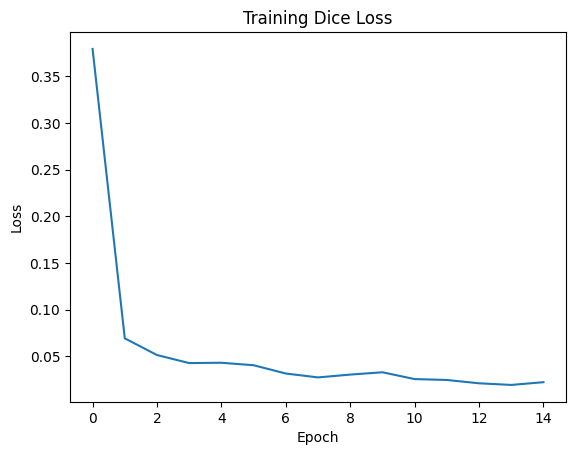

In [128]:
# Show tr_loss plot
tr_losses = [tr_metrics[epoch]['loss'] for epoch in tr_metrics]
plt.plot(tr_losses)
plt.title("Training Dice Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [129]:
checkpoint = load_checkpoint('finetuned_sam_checkpoints/512_checkpoints_new/epoch_200.pt')
model = SamModel.from_pretrained("facebook/sam-vit-base")
model.load_state_dict(checkpoint["model_state_dict"])
model.to(get_device())

metrics = evaluate(model, test_dataloader, test_images, test_masks, calc_loss=False, thresh=0.4)
metrics

Error loading checkpoint: [Errno 2] No such file or directory: 'finetuned_sam_checkpoints/512_checkpoints_new/epoch_200.pt'


TypeError: 'NoneType' object is not subscriptable